Tutorial on YouTube Chanel:
Text Visualization | Lecture 2 | CPE 393 Text Analytics
https://www.youtube.com/watch?v=rAQCQKnkNh0&t=774s

##### <b>Load Dataset</b>

In [16]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [17]:
df = pd.read_csv('un-general-debates.csv')
df.sample(5)

,session,year,country,text
3657,60,2005,GRD,I am indeed greatly\nhonoured to join those wh...
3574,54,1999,SWZ,I am honoured to address the\nGeneral Assembly...
1183,57,2002,FSM,﻿I would like to take this\nopportunity to con...
2255,65,2010,AND,It is certainly a great opportunity for the \...
5150,66,2011,NOR,"Since we last met here, \nmajor changes have s..."


In [18]:
df.count()

session    7507
year       7507
country    7507
text       7507
dtype: int64

In [19]:
# Primary key

df[['session', 'country']].drop_duplicates().count()

session    7507
country    7507
dtype: int64

##### <b>DataFrame Summary Statistics</b>

In [20]:
df['length'] = df['text'].str.len()

In [21]:
df.columns

Index(['session', 'year', 'country', 'text', 'length'], dtype='object')

In [22]:
df.dtypes

session     int64
year        int64
country    object
text       object
length      int64
dtype: object

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  7507 non-null   int64 
 1   year     7507 non-null   int64 
 2   country  7507 non-null   object
 3   text     7507 non-null   object
 4   length   7507 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 293.4+ KB


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [25]:
df[['country']].describe(include='O').T

,count,unique,top,freq
country,7507,199,IRN,46


##### <b>Check Missing Data</b>

In [26]:
df.isna().sum()

session    0
year       0
country    0
text       0
length     0
dtype: int64

##### <b>Plotting distribution</b>

<AxesSubplot:>

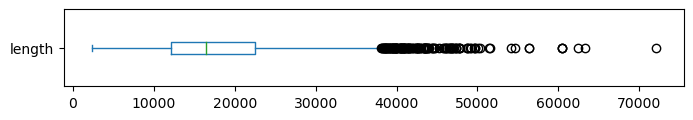

In [27]:
df['length'].plot(kind='box', vert=False, figsize=(8,1))

<AxesSubplot:ylabel='Frequency'>

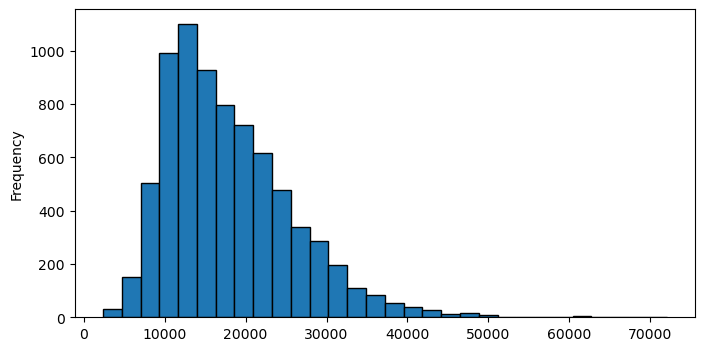

In [28]:
df['length'].plot(kind='hist', bins=30, figsize=(8,4), edgecolor='k')

##### <b>Distribution across categories</b>

c:\Users\samapant\Anaconda3\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


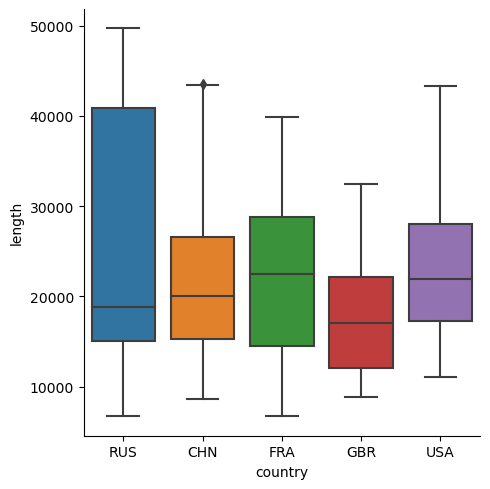

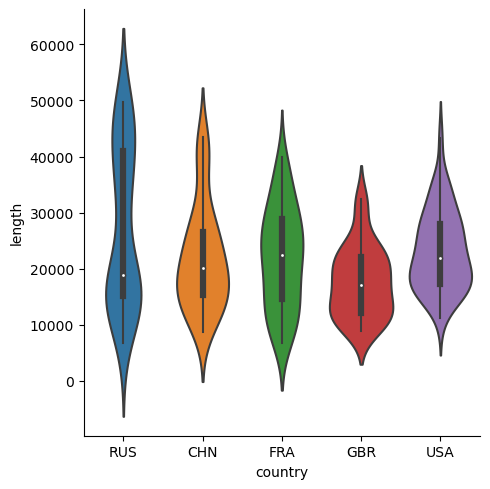

In [29]:
import seaborn as sns

where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
sns.catplot(data=df[where], x='country', y='length', kind='box')
sns.catplot(data=df[where], x='country', y='length', kind='violin')

##### <b>Developement over time Number of countries</b>

<AxesSubplot:title={'center':'Number of Countries'}, xlabel='year'>

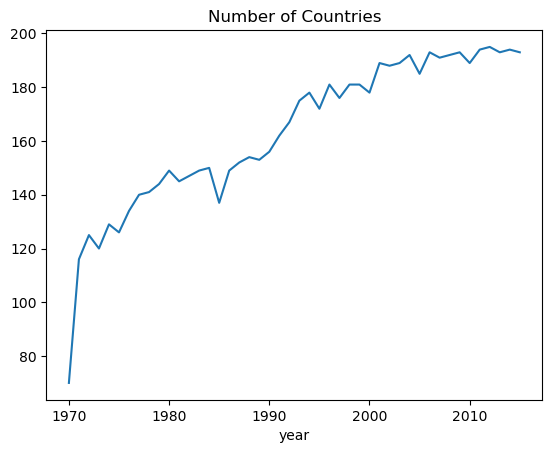

In [30]:
df.groupby('year').size().plot(title='Number of Countries')

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

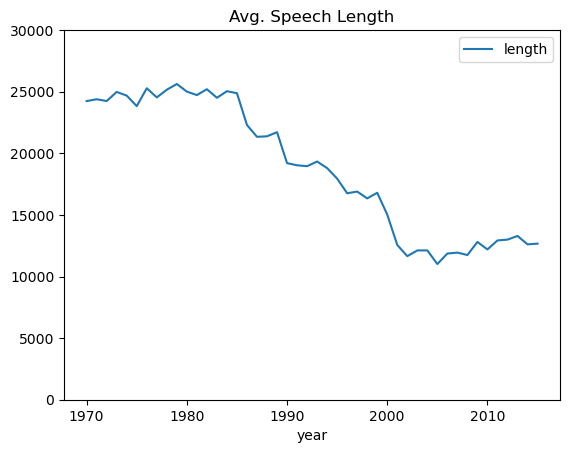

In [31]:
df.groupby('year').agg({'length':'mean'}).plot(title='Avg. Speech Length', ylim=(0,30000))

##### <b>Simple Text Processing</b>

In [32]:
# Case Folding
str.lower('Hello World')

'hello world'

In [33]:
# Tokenization

import regex as re
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [34]:
text = "Let's defeat SARS-Coc-2 together in 2021!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-Coc-2|together|in


In [35]:
# Stop word removal
import nltk
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samapant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [36]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [37]:
remove_stop(tokens)

['Let', 'defeat', 'SARS-Coc-2', 'together']

In [38]:
# Processing a pipeline

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [39]:
prepare(text, pipeline)

['let', 'defeat', 'sars-coc-2', 'together']

In [40]:
# Apply pipeline

# Series: map
# Series: map
# DaraFrame: applymap
# DataFrame: applymap

df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)
df.sample(10)

,session,year,country,text,length,tokens
5626,48,1993,SLE,"Last year, my Head of\nState, Captain Valentin...",28956,"[last, year, head, state, captain, valentine, ..."
4009,37,1982,GHA,It is with particular pleasure that I join \np...,19928,"[particular, pleasure, join, previous, speaker..."
690,63,2008,BLZ,On behalf of the \nGovernment and people of Be...,12964,"[behalf, government, people, belize, congratul..."
4742,35,1980,NOR,"﻿Mr. President, it gives me great pleasure to ...",23594,"[mr, president, gives, great, pleasure, see, d..."
238,68,2013,ECU,"It is an honour, Mr. President, for me to addr...",10120,"[honour, mr, president, address, general, asse..."
574,63,2008,AGO,I am \nparticularly honoured to address the Ge...,10742,"[particularly, honoured, address, general, ass..."
7083,61,2006,FJI,"I extend to you, Madam, the \ncongratulations ...",11303,"[extend, madam, congratulations, best, wishes,..."
2866,64,2009,HUN,Allow me at the outset to \ncongratulate the P...,9062,"[allow, outset, congratulate, president, assum..."
6146,55,2000,QAT,I should like at the outset to extend my\ncong...,18633,"[like, outset, extend, congratulations, mr, ho..."
4237,53,1998,VNM,On behalf of the delegation of the Socialist\n...,19368,"[behalf, delegation, socialist, republic, viet..."


In [41]:
# Counting number of tokens (words)
df['num_tokens'] = df['tokens'].map(len)
df.sample(10)

,session,year,country,text,length,tokens,num_tokens
4434,58,2003,VUT,﻿Allow\nme to convey to this Assembly the hear...,11024,"[allow, convey, assembly, heartfelt, greetings...",905
6607,28,1973,GTM,"﻿197.\tMr. President, the delegation of Guatem...",14700,"[mr, president, delegation, guatemala, conside...",1205
7209,62,2007,SWE,Let me take this \nopportunity to express our ...,9172,"[let, take, opportunity, express, strong, supp...",772
6158,55,2000,GIN,I am\nvery pleased on behalf of the people and...,11519,"[pleased, behalf, people, government, guinea, ...",941
3731,60,2005,AUS,Australia is a founding\nMember of the United ...,12274,"[australia, founding, member, united, nations,...",1039
6942,61,2006,IRL,"Let me begin by \ncongratulating you, Madam Pr...",13443,"[let, begin, congratulating, madam, president,...",1118
6870,27,1972,SOM,"Mr. President, my Foreign Secretary had hoped ...",34848,"[mr, president, foreign, secretary, hoped, abl...",2803
2627,50,1995,EGY,It\ngives me great pleasure to extend to the P...,36281,"[gives, great, pleasure, extend, president, fr...",2973
6116,55,2000,JPN,"First, I would like to\nextend my heartfelt co...",21366,"[first, would, like, extend, heartfelt, congra...",1828
3459,34,1979,COG,﻿Among the events which have shaken the world ...,19644,"[among, events, shaken, world, especially, afr...",1600


In [42]:
# 56:22